In [ ]:
!nvidia-smi

Sat Dec 14 14:11:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!rm -r /content/processed_data

rm: cannot remove '/content/processed_data': No such file or directory


In [ ]:
!wget https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/d29ed9b2-8a5d-4663-8a82-c9174f2c7066 -O file.zip
!unzip file.zip


Streaming output truncated to the last 5000 lines.
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (132).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1320).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1321).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1322).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1323).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1325).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/i

In [ ]:
!find /content/Plant_leave_diseases_dataset_without_augmentation -type f | awk -F. '{if (NF>1) print $NF}' | sort -u

jpeg
jpg
JPG
png


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, DenseNet121, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
import gc
from collections import Counter
import logging
from tqdm import tqdm

logging.basicConfig(level=logging.INFO)

class DataPreprocessor:
    def __init__(self, data_dir: str, img_size: Tuple[int, int] = (224, 224)):
        self.data_dir = Path(data_dir)
        self.img_size = img_size
        self.train_dir = Path('processed_data/train')
        self.valid_dir = Path('processed_data/valid')
        self.test_dir = Path('processed_data/test')

    def _get_file_paths(self) -> Dict[str, List[str]]:
        """Get all image paths and their corresponding labels"""
        image_paths = []
        labels = []
        extensions = ['*.jpg', '*.png', '*.jpeg', '*.JPG']

        for class_dir in self.data_dir.iterdir():
            if class_dir.is_dir():
                for ext in extensions:
                    for img_path in class_dir.glob(ext):
                        image_paths.append(str(img_path))
                        labels.append(class_dir.name)

        return {'paths': image_paths, 'labels': labels}

    def analyze_class_distribution(self, labels: List[str]) -> Dict[str, int]:
        """Analyze and print class distribution"""
        distribution = Counter(labels)
        print("Class distribution:")
        for class_name, count in distribution.items():
            print(f"{class_name}: {count}")
        return distribution

    def create_directory_structure(self):
        """Create directory structure for train/valid/test splits"""
        for dir_path in [self.train_dir, self.valid_dir, self.test_dir]:
            if dir_path.exists():
                shutil.rmtree(dir_path)
            dir_path.mkdir(parents=True)

        data = self._get_file_paths()
        unique_labels = set(data['labels'])

        for split_dir in [self.train_dir, self.valid_dir, self.test_dir]:
            for label in unique_labels:
                (split_dir / label).mkdir(parents=True, exist_ok=True)

    def copy_files(self, files: List[str], labels: List[str], dest_base_dir: Path):
        """Copy files to destination directory maintaining structure"""
        for file_path, label in tqdm(zip(files, labels), desc=f"Copying files to {dest_base_dir.name}"):
            dest_dir = dest_base_dir / label
            dest_file = dest_dir / Path(file_path).name
            shutil.copy2(file_path, dest_file)

    def split_dataset(self, train_ratio=0.7, val_ratio=0.15):
        """Split dataset into train, validation, and test sets with stratification"""
        data = self._get_file_paths()
        self.analyze_class_distribution(data['labels'])

            # Check for classes with only one sample and handle them:
        label_counts = Counter(data['labels'])
        single_sample_classes = [label for label, count in label_counts.items() if count == 1]

        # Option 1: Remove classes with only one sample:
        if single_sample_classes:
            logging.warning(f"Removing classes with only one sample: {single_sample_classes}")
            # data['paths'] = [path for path, label in zip(data['paths'], data['labels']) if label not in single_sample_classes]
            # data['labels'] = [label for label in data['labels'] if label not in single_sample_classes]

        # Create stratified train and temp splits
        X_train, X_temp, y_train, y_temp = train_test_split(
            data['paths'],
            data['labels'],
            train_size=train_ratio,
            stratify=data['labels'],
            random_state=42
        )

        # Split temp into validation and test
        val_ratio_adjusted = val_ratio / (1 - train_ratio)
        X_valid, X_test, y_valid, y_test = train_test_split(
            X_temp,
            y_temp,
            train_size=val_ratio_adjusted,
            stratify=y_temp,
            random_state=42
        )

        # Create directory structure and copy files
        self.create_directory_structure()
        self.copy_files(X_train, y_train, self.train_dir)
        self.copy_files(X_valid, y_valid, self.valid_dir)
        self.copy_files(X_test, y_test, self.test_dir)

        # Calculate class weights for handling imbalance
        class_weights = self._calculate_class_weights(y_train)
        return class_weights

    def _calculate_class_weights(self, y_train: List[str]) -> Dict[int, float]:
        """Calculate class weights to handle class imbalance"""
        counter = Counter(y_train)
        max_samples = max(counter.values())
        return {i: max_samples/count for i, (label, count) in
                enumerate(counter.items())}

    def create_data_generators(self):
        """Create data generators with augmentation for training"""
        train_datagen = ImageDataGenerator(
            rescale=1./255,  # Normalization
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        valid_test_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_directory(
            self.train_dir,
            target_size=self.img_size,
            batch_size=100,
            class_mode='categorical',
            shuffle=True
        )

        valid_generator = valid_test_datagen.flow_from_directory(
            self.valid_dir,
            target_size=self.img_size,
            batch_size=100,
            class_mode='categorical',
            shuffle=False
        )

        test_generator = valid_test_datagen.flow_from_directory(
            self.test_dir,
            target_size=self.img_size,
            batch_size=100,
            class_mode='categorical',
            shuffle=False
        )

        return train_generator, valid_generator, test_generator



In [ ]:
class BaseModel:
    def __init__(self, model_name: str, img_size: Tuple[int, int], num_classes: int):
        self.model_name = model_name
        self.img_size = img_size
        self.num_classes = num_classes
        self.model = self._create_model()

    def _create_model(self):
        input_shape = (*self.img_size, 3)

        if self.model_name == 'efficientnet':
            base = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
        elif self.model_name == 'densenet':
            base = DenseNet121(include_top=False, input_shape=input_shape, weights='imagenet')
        elif self.model_name == 'resnet':
            base = ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')

        # Freeze base model layers
        base.trainable = False

        model = models.Sequential([
            base,
            layers.GlobalAveragePooling2D(),
            layers.BatchNormalization(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        return model

    def train(self, train_gen, valid_gen, class_weights, epochs=1):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall()]
        )

        history = self.model.fit(
            train_gen,
            validation_data=valid_gen,
            epochs=epochs,
            class_weight=class_weights,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True
                ),
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.2,
                    patience=3
                )
            ]
        )

        # Clear memory
        gc.collect()
        return history

    def predict(self, data_gen):
        return self.model.predict(data_gen)

In [ ]:
class MetaModel:
    def __init__(self, num_classes: int, input_shape: Tuple[int, ...]):
        self.num_classes = num_classes
        self.model = self._create_model(input_shape)

    def _create_model(self, input_shape):
        model = models.Sequential([
            layers.Dense(256, activation='relu', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall()]
        )

        return model

In [ ]:
class MetricsPlotter:
    @staticmethod
    def plot_training_metrics(histories: List[dict], model_names: List[str]):
        """Plot training and validation metrics for all models"""
        import re  # Add import at the top of the file if not already present

        # Define metric bases we want to plot
        metric_bases = ['loss', 'accuracy', 'precision', 'recall']

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))
        axes = axes.ravel()

        # Plot each metric type
        for idx, metric_base in enumerate(metric_bases):
            for history, name in zip(histories, model_names):
                # Find the metrics that match our base (including numbered versions)
                train_metric = next((key for key in history.keys()
                                   if metric_base in key.lower()
                                   and not key.startswith('val')), None)
                val_metric = next((key for key in history.keys()
                                 if metric_base in key.lower()
                                 and key.startswith('val')), None)

                if train_metric:
                    axes[idx].plot(history[train_metric], label=f'{name} (train)')
                if val_metric:
                    axes[idx].plot(history[val_metric], label=f'{name} (val)')

                # Clean up metric name for display by removing any numeric suffixes
                display_metric = re.sub(r'_\d+$', '', metric_base).title()
                axes[idx].set_title(f'Model {display_metric}')
                axes[idx].set_xlabel('Epoch')
                axes[idx].set_ylabel(display_metric)
                axes[idx].legend()

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_classification_metrics(y_true, y_pred, model_name: str):
        """Plot classification metrics"""
        metrics = {
            'Accuracy': accuracy_score(y_true, y_pred),
            'F1 Score': f1_score(y_true, y_pred, average='weighted'),
            'Precision': precision_score(y_true, y_pred, average='weighted'),
            'Recall': recall_score(y_true, y_pred, average='weighted')
        }

        plt.figure(figsize=(10, 6))
        bars = plt.bar(metrics.keys(), metrics.values())
        plt.title(f'Classification Metrics - {model_name}')
        plt.ylim(0, 1)

        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom')

        plt.show()

        # Print metrics
        for metric, value in metrics.items():
            print(f"{model_name} - {metric}: {value:.3f}")


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:

# Initialize data preprocessor
data_dir = "/content/Plant_leave_diseases_dataset_without_augmentation/"  # Update with your dataset path
preprocessor = DataPreprocessor(data_dir)
meta_epoch = 1

# Split dataset and get class weights
class_weights = preprocessor.split_dataset()

# Create data generators
train_gen, valid_gen, test_gen = preprocessor.create_data_generators()

# Initialize base models
base_models = [
    BaseModel('efficientnet', (224, 224), num_classes=len(train_gen.class_indices)),
    BaseModel('densenet', (224, 224), num_classes=len(train_gen.class_indices)),
    BaseModel('resnet', (224, 224), num_classes=len(train_gen.class_indices))
]




Class distribution:
Soybean___healthy: 5090
Squash___Powdery_mildew: 1835
Corn___Cercospora_leaf_spot Gray_leaf_spot: 513
Tomato___Target_Spot: 1404
Apple___Black_rot: 621
Strawberry___healthy: 456
Corn___healthy: 1162
Cherry___healthy: 854
Tomato___Late_blight: 1909
Peach___Bacterial_spot: 2297
Corn___Northern_Leaf_Blight: 985
Potato___Late_blight: 1000
Grape___Esca_(Black_Measles): 1383
Tomato___Early_blight: 1000
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076
Corn___Common_rust: 1192
Background_without_leaves: 1143
Strawberry___Leaf_scorch: 1109
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 5357
Tomato___Leaf_Mold: 952
Orange___Haunglongbing_(Citrus_greening): 5507
Raspberry___healthy: 371
Pepper,_bell___healthy: 1478
Grape___healthy: 423
Apple___healthy: 1645
Grape___Black_rot: 1180
Pepper,_bell___Bacterial_spot: 997
Tomato___Spider_mites Two-spotted_spider_mite: 1676
Potato___Early_blight: 1000
Potato___healthy: 152
Apple___Apple_scab: 630
Tomato___Septoria_leaf_spot: 1771
Cherry___Po

Copying files to train: 38813it [00:11, 3412.93it/s]
Copying files to valid: 8317it [00:01, 6068.01it/s]
Copying files to test: 8318it [00:01, 5869.58it/s]


Found 38813 images belonging to 39 classes.
Found 8317 images belonging to 39 classes.
Found 8318 images belonging to 39 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#!pip install mlflow

Training efficientnet


2024/12/14 14:32:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd986976602574098acf57946a2cfc931', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/12/14 14:32:42 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2024/12/14 14:32:42 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0750 - loss: 25.4822 - precision: 0.0680 - recall: 0.0013

389/389 ━━━━━━━━━━━━━━━━━━━━ 574s 1s/step - accuracy: 0.0750 - loss: 25.4789 - precision: 0.0681 - recall: 0.0013 - val_accuracy: 0.0965 - val_loss: 3.5823 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04


2024/12/14 14:42:19 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2024/12/14 14:42:19 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/12/14 14:42:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


389/389 ━━━━━━━━━━━━━━━━━━━━ 467s 1s/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 22s 262ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


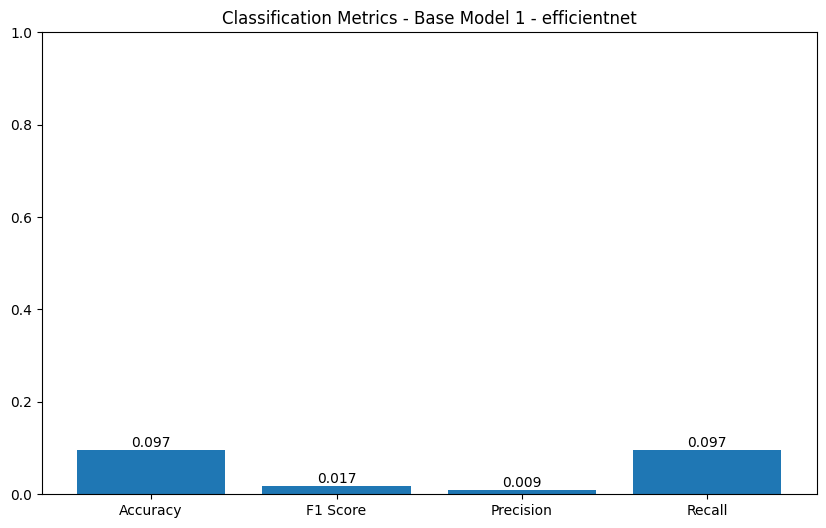

2024/12/14 14:51:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bd01722d7e9f4f81b7451119ff90c472', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Base Model 1 - efficientnet - Accuracy: 0.097
Base Model 1 - efficientnet - F1 Score: 0.017
Base Model 1 - efficientnet - Precision: 0.009
Base Model 1 - efficientnet - Recall: 0.097
Training densenet


2024/12/14 14:51:26 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2024/12/14 14:51:26 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


315/389 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.1674 - loss: 22.5700 - precision_1: 0.5494 - recall_1: 0.0704

KeyboardInterrupt: 

In [ ]:


# Train base models and collect predictions
histories = []
train_predictions = []
valid_predictions = []
test_predictions = []

for idx, model in enumerate(base_models):
    print(f"Training {model.model_name}")
    history = model.train(train_gen, valid_gen, class_weights)
    histories.append(history.history)

    # Generate predictions
    train_predictions.append(model.predict(train_gen))
    valid_predictions.append(model.predict(valid_gen))
    test_predictions.append(model.predict(test_gen))

    # Plot individual model metrics
    MetricsPlotter.plot_classification_metrics(
        # np.argmax(test_gen.labels, axis=1),
        test_gen.labels,
        np.argmax(test_predictions[-1], axis=1),
        f"Base Model {idx+1} - {model.model_name}"
    )


In [ ]:
import mlflow
mlflow.tensorflow.autolog()


# Start MLflow experiment

mlflow.set_experiment("PlantVillage_Classification_Ensemble_v1.0")

with mlflow.start_run():
    # Log hyperparameters : We can add more as per the ensemble model outputs and also class weights.

    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)

    # Create and compile model : Change here for Ensemble Model
    model = create_cnn_with_mobilenetv2(K)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=67,
        steps_per_epoch=350,
        validation_steps=350,
        class_weight=class_weights  # Optional: Use class weights if dataset is imbalanced
    )

    # Evaluate the model on validation data
    val_loss, val_accuracy = model.evaluate(validation_data)

    # The below remains the same , we can add more metrics as per our tracking requirements.
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("val_accuracy", val_accuracy)

    # Save the model
    model.save("/content/drive/My Drive/Augmented_PlantVillage/plant_village_model_mobnet.keras")

    mlflow.tensorflow.log_model(model,
                                 artifact_path="keras_model")

In [ ]:
# Prepare meta-features
meta_train = np.concatenate(train_predictions, axis=1)
meta_valid = np.concatenate(valid_predictions, axis=1)
meta_test = np.concatenate(test_predictions, axis=1)

# Train meta model
print("Training meta model")
meta_model = MetaModel(
    num_classes=len(train_gen.class_indices),
    input_shape=(meta_train.shape[1],)
)


In [ ]:
meta_model

In [ ]:
y_train_onehot = tf.keras.utils.to_categorical(train_gen.labels, num_classes=len(train_gen.class_indices))
y_valid_onehot = tf.keras.utils.to_categorical(valid_gen.labels, num_classes=len(train_gen.class_indices))

meta_history = meta_model.model.fit(

    meta_train, y_train_onehot,
    validation_data=(meta_valid, y_valid_onehot),
    epochs=meta_epoch,
    class_weight=class_weights,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# Plot training metrics
MetricsPlotter.plot_training_metrics(
    histories + [meta_history.history],
    ['EfficientNet', 'DenseNet', 'ResNet', 'Meta Model']
)
# Plot final ensemble metrics
final_predictions = meta_model.model.predict(meta_test)
MetricsPlotter.plot_classification_metrics(
    # np.argmax(test_gen.labels, axis=1),
    test_gen.labels,
    np.argmax(final_predictions, axis=1),
    'Final Stacking Ensemble'
)